In [36]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from statistics import median
from tqdm.notebook import tqdm
import statistics as stat
import numpy as np

folder = os.path.join('H:/','My Drive','PROJECTS','Cai Darby projects','PSI PDART LIBS (2023-2024)','XRF fundamentals vs. MVA')

This notebook conducts a new set of analyses to account for changing the methods. And to have it all in one clear place!

### Make unified metadata file

In [31]:
# stratify
stratify_script = 'C:/Users/ytsma22c/Documents/GitHub/caipy/stratify_samples.py'
mpath = os.path.join(folder,'data','meta_both.csv')
%run {stratify_script} -m "{mpath}" -n 5

Exported meta_both_stratified.csv


I then renamed it to 'meta_key_stratified'

In [39]:
# REMOVE OUTLIERS
meta_key = pd.read_csv(os.path.join(folder,'data','meta_key_stratified.csv'))
# use IQR based on LOQ paper
limits = pd.read_csv('Z:\\Millennium Set\\NEW_OUTLIER_LIMITS.csv')
limits = dict(zip(limits.element, limits.iqr_q3_outlier_limit))

# get elements
elem = [x.split('_')[0] for x in meta_key.columns if '_Folds' in x]

# assign outliers to -1 fold
for e in elem:
    # for S, convert to wt%
    if e == 'SO3':
        lim = limits['S'] / 10000
    else:
        lim = limits[e]
    for i in meta_key.index:
        x = meta_key[e].iloc[i]
        if x == np.nan:
            continue
        elif x <= lim:
            continue
        else:
            meta_key.iloc[i, meta_key.columns.get_loc(e+'_Folds')] = -1
            
meta_key.to_csv(os.path.join(folder,'data','meta_key_stratified_outliers_removed.csv'), index=False)

In [44]:
# merge with other files
for m in ['both','filter1','filter2']:
    met = pd.read_csv(os.path.join(folder,'data',f'meta_{m}.csv'))
    met = met.merge(meta_key.drop(columns=['pkey']))
    met.to_csv(os.path.join(folder,'data',f'meta_{m}_stratified_outliers_removed.csv'), index=False)

### Plot compositions

In [45]:
# info for plotting
key = {
    'maj_min':{
        'elem':['SiO2','TiO2','Al2O3','Fe2O3','MgO','MnO','CaO','P2O5'],
        'units':'wt%',
        'cols':2,
        'rows':4,
        'fig':(8,10),
        'xs':[0,0,1,1,2,2,3,3],
        'ys':[0,1]*4
    },
    'trace':{
        'elem':['As','Bi','Cr','Cu','Mo','Nb','Ni','Pb','Rb','SO3','Sn','Sr','Ta','Th','U','V','W','Y','Zn','Zr'],
        'units':'ppm',
        'cols':3,
        'rows':7,
        'fig':(10,16),
        'xs':[0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6],
        'ys':[0,1,2]*7        
        #'xs':[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4],
        #'ys':[0,1,2,3]*5     
    }
}

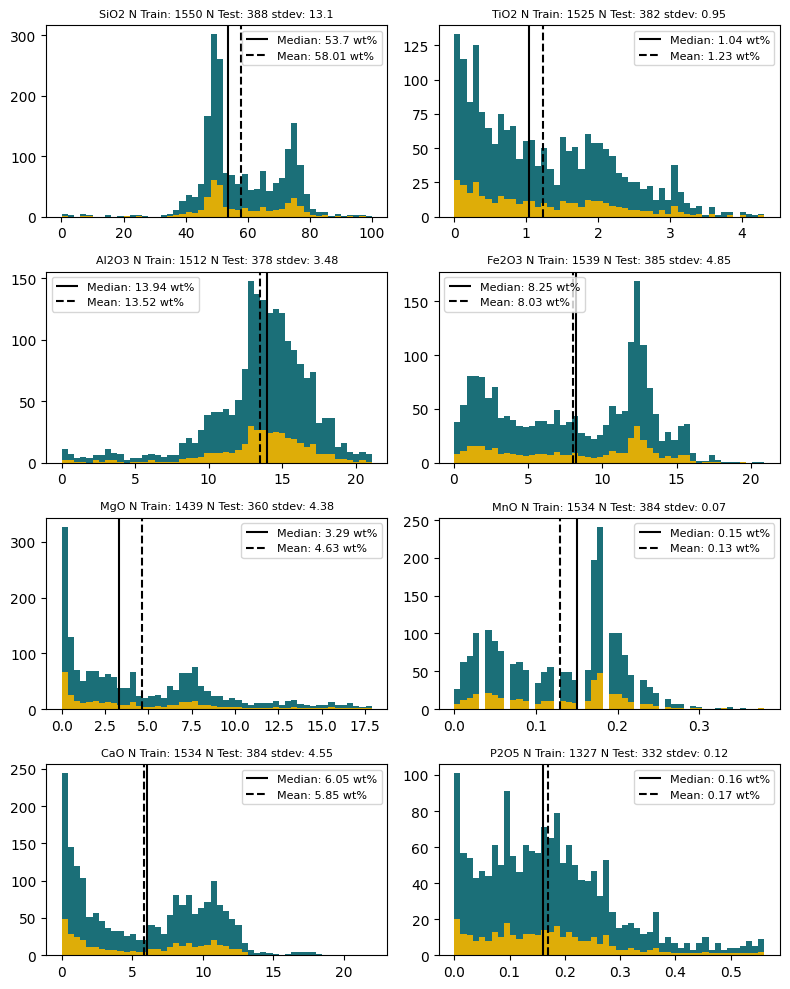

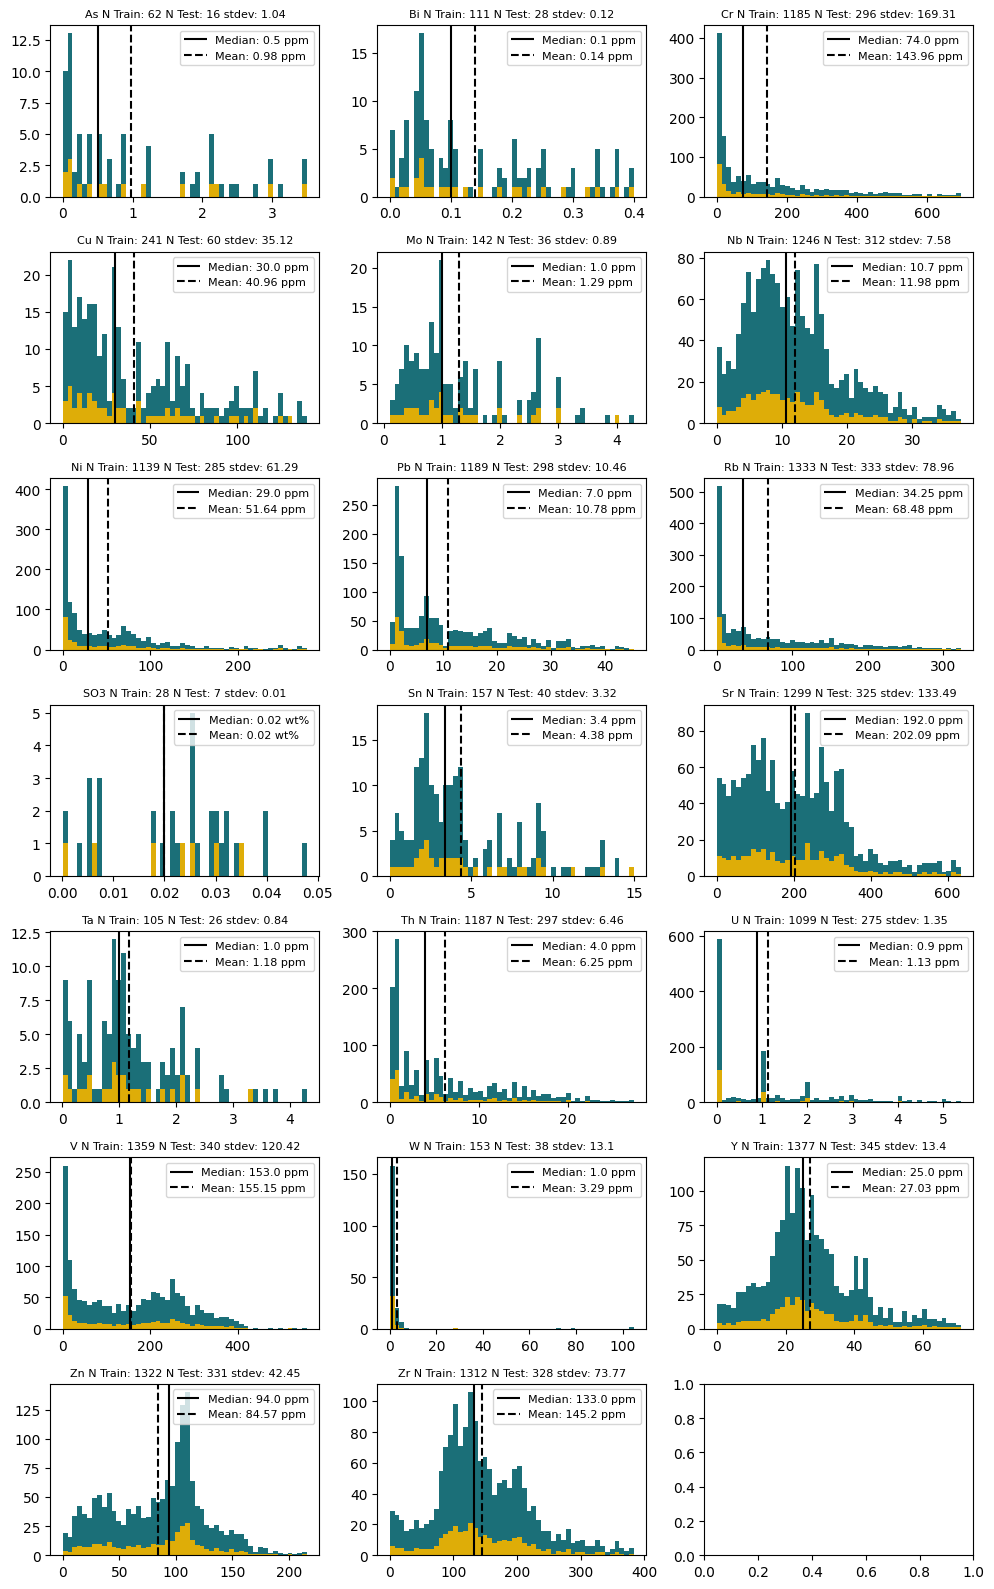

In [46]:
meta = pd.read_csv(os.path.join(folder,'data','meta_key_stratified_outliers_removed.csv'))
# use fold 2 as test fold
b=50

# also extract N, median, mean, etc.
summary_dict = {}
for kind in key.keys():
    
    elem = key[kind]['elem']
    x=key[kind]['xs']
    y=key[kind]['ys']
    cols=key[kind]['cols']
    rows=key[kind]['rows']
    fig=key[kind]['fig']
    
    fig, ax = plt.subplots(ncols=cols,
                           nrows=rows,
                           figsize=fig)

    for i, e in enumerate(elem):
        if e == 'SO3':
            units='wt%'
        else:
            units=key[kind]['units']
        
        temp = meta[(~meta[e].isna())&(meta[e+'_Folds']!=-1)][[e,e+'_Folds']].copy()
        median = round(stat.median(temp[e].values),2)
        mean = round(stat.mean(temp[e].values),2)
        std = round(stat.stdev(temp[e].values),2)

        temp_test = temp[temp[e+'_Folds']==2].copy()
        temp_train = temp[temp[e+'_Folds']!=2].copy()
        n_test = len(temp_test)
        n_train = len(temp_train)
        
        # add data to lists
        summary_dict[e] = {
            'n_train':n_train,
            'n_test':n_test,
            'units':units,
            'median':median,
            'mean':mean,
            'stdev':std
        }
        
        ax[x[i],y[i]].hist((temp_test[e].values, temp_train[e].values), 
                           bins=b, 
                           color=['#dead08','#1b6f78'],
                           stacked=True)

        # get ylims
        ymin, ymax = ax[x[i],y[i]].get_ylim()

        ax[x[i],y[i]].vlines(median, ymin, ymax, colors='black', linestyle='solid', label=f'Median: {median} {units}')
        ax[x[i],y[i]].vlines(mean, ymin, ymax, colors='black', linestyle='dashed', label=f'Mean: {mean} {units}')
        ax[x[i],y[i]].set_ylim(ymin, ymax)

        ax[x[i],y[i]].legend(fontsize=8)
        title = f'{e} N Train: {n_train} N Test: {n_test} stdev: {std}'
        ax[x[i],y[i]].set_title(title, fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(folder,'figures','histogram_{kind}.eps'), dpi=600)
    plt.show()

### Train models

In [47]:
model_script = 'C:/Users/ytsma22c/Documents/GitHub/caipy/spectral_regression_modelling.py'
for run in tqdm(['both','filter1','filter2']):
    bdata_folder = os.path.join(folder,'data')
    bmodel_folder = os.path.join(folder,'models',run)
    ssname = f'spectra_{run}.csv'
    mmname = f'meta_{run}_stratified_outliers_removed.csv'
    %run {model_script} -f "{bdata_folder}" -o "{bmodel_folder}" -s {ssname} -m {mmname} -mt 1,2,3,4,5,6,7 -mc 30 -hp -std -dt -tf 2

  0%|          | 0/3 [00:00<?, ?it/s]

Identified variable(s) to model: Al2O3, As, Bi, CaO, Cr, Cu, Fe2O3, Hg, MgO, MnO, Mo, Nb, Ni, P2O5, Pb, Rb, SO3, SiO2, Sn, Sr, Ta, Th, TiO2, U, V, W, Y, Zn, Zr

Performing OLS, PLS, OMP, LASSO, ElasticNet, Ridge, PCR-lin regressions

Running for Al2O3
min samples: 378

Performing CV for OLS
OLS does not optimize

Training model
	RMSE-C: 0.0    R2: 1.0    Adjusted R2: 1.0

Testing model
	RMSE-P: 12.07    R2: -10.954    Adjusted R2: -11.018

Performing CV for PLS

Training model
	RMSE-C: 3.092    R2: 0.209    Adjusted R2: 0.208

Testing model
	RMSE-P: 3.163    R2: 0.179    Adjusted R2: 0.175

Performing CV for OMP
OMP does not optimize

Training model
	RMSE-C: 0.776    R2: 0.95    Adjusted R2: 0.95

Testing model
	RMSE-P: 12.701    R2: -12.238    Adjusted R2: -12.308

Performing CV for LASSO

Training model
	RMSE-C: 0.129    R2: 0.999    Adjusted R2: 0.999

Testing model
	RMSE-P: 21.44    R2: -36.72    Adjusted R2: -36.921

Performing CV for ElasticNet

Training model
	RMSE-C: 1.109    R

In [25]:
# compile
script_path = 'C:/Users/ytsma22c/Documents/GitHub/caipy/merge_model_results.py'
mfolder = os.path.join(folder,'models')
%run {script_path} -f "{mfolder}"

3 folders found
3 modelling_results.csv files found
exported cumulative_modelling_results.csv


### Select the input data that is best per element based on PLS model.

In [2]:
results = pd.read_csv(os.path.join(folder,'models','cumulative_modelling_train_test_results.csv'))

In [3]:
best_filter = (results
                [(results['model type']=='PLS') &
                ~(results['variable'].isin(['Hg','Cl']))]
                [['filter','variable','RMSE-P']]
                .sort_values('RMSE-P')
                .drop_duplicates(subset='variable', 
                                keep='first',
                                ignore_index=True))
# export this info
best_filter[['filter','variable']].to_csv(os.path.join(folder,'best_filter_per_element_PLS_model.csv'), index=False)
# make key
best_filter = dict(zip(best_filter['variable'], best_filter['filter']))

Filter for these filter results

In [4]:
best_results = pd.DataFrame()
for var in best_filter.keys():
    temp = results[
        (results['variable']==var) &
        (results['filter'] == best_filter[var])
    ].copy()
    best_results = pd.concat([best_results,temp], ignore_index=True)

Get the %RMSE-P for each method from that beam - make plot comparing

In [5]:
summary = pd.read_csv(os.path.join(folder,'data','dataset_summary.csv'))
# drop PCR-py, I shouldn't have run it
# also drop OMP because it was so much worse?
test_df = best_results[~best_results['model type'].isin(['PCR-py'])].copy().reset_index(drop=True)

# get %RMSEP from median concentration
test_df = test_df.merge(summary[['element','median']], how='left', left_on='variable', right_on='element').drop(columns='element')
for var in ['RMSE-P','RMSE-CV','RMSE-C']:
    test_df['%'+var] = (test_df[var] / test_df['median'])*100
test_df.drop(columns='median', inplace=True)

# set R2 < 0 to 0
for var in ['R2 test','R2 train']:
    test_df[var] = [0 if x < 0 else x for x in test_df[var]]
    
# summarize
summary_df = test_df.groupby('model type', as_index=False)['%RMSE-P'].mean().rename(columns={'%RMSE-P':'mean_%RMSE-P'})
summary_df['stdev_%RMSE-P'] = list(test_df.groupby('model type')['%RMSE-P'].std())

# sort based on my choice
summary_df['model_cat'] = pd.Categorical(
    summary_df['model type'], 
    categories=['OLS','PLS','LASSO','Ridge','ElasticNet','PCR-lin'], #'OMP',
    ordered=True
)
summary_df = summary_df.sort_values('model_cat', ignore_index=True)
summary_df.to_csv(os.path.join(folder,'models','summarized_results.csv'), index=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


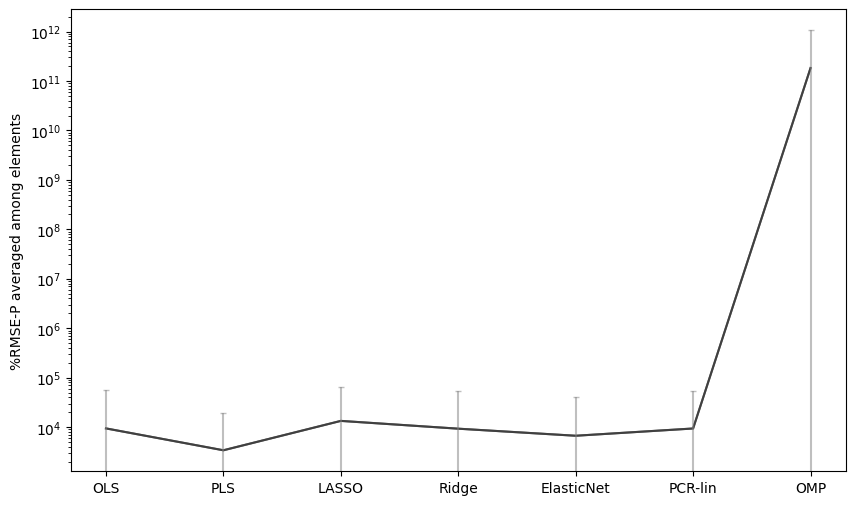

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(summary_df['model type'], summary_df['mean_%RMSE-P'], color='black')
ax.errorbar(summary_df['model type'], summary_df['mean_%RMSE-P'], capsize=2, alpha=0.5, color='grey', yerr=summary_df['stdev_%RMSE-P'])  
ax.semilogy()
plt.ylabel('%RMSE-P averaged among elements')
plt.savefig(os.path.join(folder,'figures','model_comparison_avg_by_element.eps'), dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


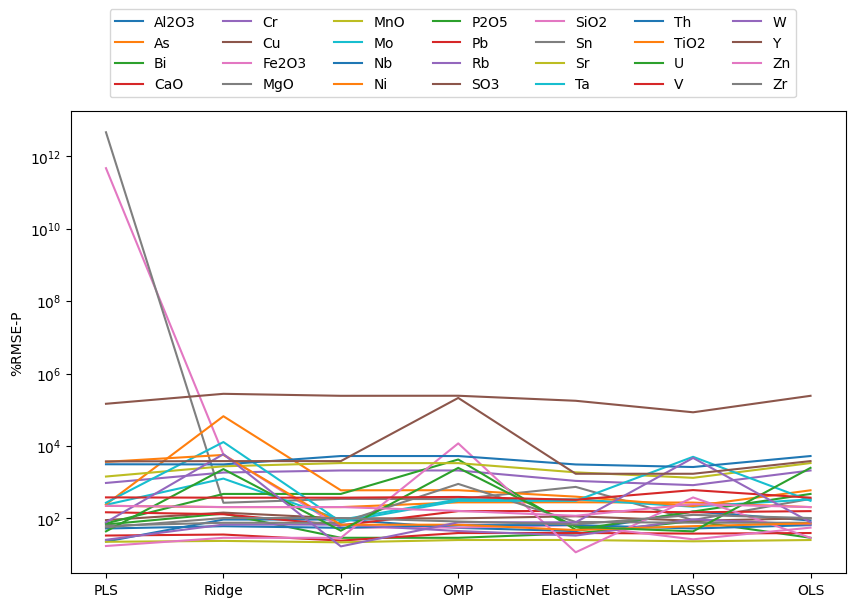

In [7]:
#cs=['#dead08','#1b6f78','#78241b']

fig,ax = plt.subplots(figsize=(10,6))

test_df.set_index('model type').groupby('variable')['%RMSE-P'].plot(legend=True)
ax.semilogy()
plt.xlabel('')
plt.ylabel('%RMSE-P')
plt.legend(loc=[0.05,1.03],ncol=7)
plt.savefig(os.path.join(folder,'figures','model_comparison_per_element.eps'), dpi=600)
plt.show()

Try ranking them, and see the one with the highest rank?

In [8]:
model_rank_df = pd.DataFrame()
for var in test_df['variable']:
    temp = (test_df
            [(test_df['variable']==var)]
            [['model type','%RMSE-P']]
            .sort_values('%RMSE-P', ignore_index=True)
            .reset_index()
            [['model type','index']]
            .rename(columns={'index':'rank'})).copy()
    # make the rank start at 1
    temp['rank'] = temp['rank']+1
    model_rank_df = pd.concat([model_rank_df,temp],ignore_index=True)

model_rank_df = (model_rank_df
                 .groupby('model type', as_index=False)
                 ['rank'].agg(['mean','std']).
                 sort_values('mean', ignore_index=True))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


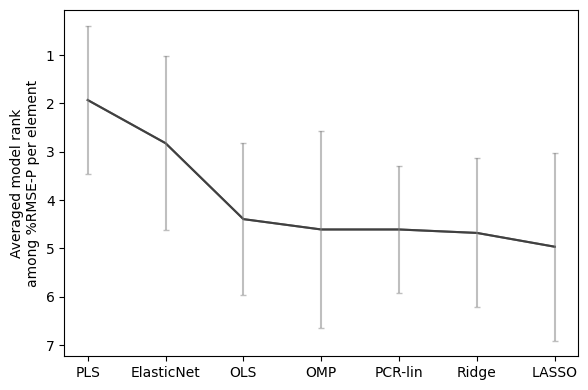

In [9]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(model_rank_df['model type'], model_rank_df['mean'], color='black')
ax.errorbar(model_rank_df['model type'], model_rank_df['mean'], capsize=2, alpha=0.5, color='grey', yerr=model_rank_df['std'])  
plt.gca().invert_yaxis()
plt.ylabel('Averaged model rank\namong %RMSE-P per element')
plt.tight_layout()
plt.savefig(os.path.join(folder,'figures','model_comparison_avg_rank_by_element.eps'), dpi=600)
plt.savefig(os.path.join(folder,'figures','model_comparison_avg_rank_by_element.jpg'), dpi=600)
plt.show()

## Calculate LOQ

In [10]:
outlier_info = {
    'TiO2':4.25,
    'MgO':15,
    'MnO':0.35,
    'CaO':28,
    'Cu':300,
    'Nb':90,
    'Pb':120,
    'Rb':350,
    'U':9,
    'V':1400,
    'Zn':270
}

### FP

Predicted vs true

In [11]:
# ACTUAL VALUES
meta = pd.read_csv(os.path.join(folder,'data','meta_both.csv'))
#format
meta.drop(columns='Sample_Name',inplace=True)
fold_col = [x for x in meta.columns if 'Folds' in x]
fold_df = meta[['pkey']+fold_col]
meta.drop(columns=fold_col, inplace=True)
# get elements
element_list = list(meta.columns[1:])
element_list.remove('Hg')
# continue formatting
new = [x+'_actual' for x in meta.columns[1:]]
new.insert(0,'pkey')
meta.columns=new

# PREDICTED VALUES
fp = pd.read_csv(os.path.join(folder,'instrument_predictions.csv'))
# format
fp = fp.drop(columns=['TestID','pkey'])
# take average
fp = fp.groupby('pellet_name', as_index=False).agg('mean')
to_drop = [x for x in fp.columns if '+/-' in x]
fp.drop(columns=to_drop, inplace=True)
fp.columns = [x.split(' ')[0] for x in fp.columns]
new = [x+'_pred' for x in fp.columns[1:]]
new.insert(0,'pkey')
fp.columns=new


# merge
fp_full = meta.merge(fp)
#format
cols = list(fp_full.columns[1:])
cols.sort()
cols.insert(0,'pkey')
fp_full = fp_full[cols]
fp_full.to_csv(os.path.join(folder,'instrument_pred_true.csv'), index=False)

Add LOQ, recalc RMSEP

In [12]:
fp_loq_df = pd.read_csv(os.path.join(folder,'Olympus_LOD_summary.csv'))
# using the average LOQ
fp_loq = dict(zip(fp_loq_df.element, fp_loq_df.average))
# sub in the ones that have to use th elowest prediction
fp_loq['Bi'] = 11
fp_loq['Ta'] = 7

In [13]:
fp_full = pd.read_csv(os.path.join(folder,'instrument_pred_true.csv'))

In [14]:
fp_result_dict = {}
for element in element_list:
    
    outliers = list(fold_df[fold_df[f'{element}_Folds']==-1]['pkey'])
    
    p = f'{element}_pred'
    t = f'{element}_actual'
    temp = fp_full[(~fp_full[p].isna())&
                   (~fp_full[t].isna())&
                   (~fp_full['pkey'].isin(outliers))].copy()
    len1 = len(temp)
    
    if element in outlier_info.keys():
        p_max = outlier_info[element]
        temp = temp[temp[p]<p_max].copy()
        print(element, 'has a prediction limit of', p_max, 'and', (len1-len(temp)), 'samples were dropped')

    # median
    med = round(median(temp[t].values),2)
    n = len(temp)
    # RMSEP
    rmsep = sqrt(mean_squared_error(temp[t], temp[p]))
    per_rmsep = rmsep / med
    # R2
    r2 = r2_score(temp[t], temp[p])
    adj_r2 = 1 - (1-r2)*(len(temp) - 1) / (len(temp) - (temp.shape[1] - 1) - 1)

    # LOQ
    loq = fp_loq[element]
    # remove those below LOQ
    temp_above_loq = temp[temp[p]>loq].copy()
    # recalculate metrics
    rev_rmsep = sqrt(mean_squared_error(temp_above_loq[t], temp_above_loq[p]))
    rev_per_rmsep = rev_rmsep / med
    rev_r2 = r2_score(temp_above_loq[t], temp_above_loq[p])
    rev_adj_r2 = 1 - (1-rev_r2)*(len(temp_above_loq) - 1) / (len(temp_above_loq) - (temp_above_loq.shape[1] - 1) - 1)
    rev_median = round(median(temp_above_loq[t].values),2)
    rev_n_test = len(temp_above_loq)
    
    fp_result_dict[element] = {
        'element':element,
        'n_test':n,
        'median_conc':med,
        'rmsep':rmsep,
        'per_rmsep':per_rmsep,
        'r2':r2,
        'adj_r2':adj_r2,
        'loq':loq,
        'n_test_above_loq':rev_n_test,
        'median_conc_above_loq':rev_median,
        'rmsep_above_loq':rev_rmsep,
        'per_rmsep_above_loq':rev_per_rmsep,
        'r2_above_loq':rev_r2,
        'adj_r2_above_loq':rev_adj_r2
    }      
# export
fp_results = pd.DataFrame.from_dict(fp_result_dict, orient='index')

CaO has a prediction limit of 28 and 2 samples were dropped
Cu has a prediction limit of 300 and 2 samples were dropped
MgO has a prediction limit of 15 and 1 samples were dropped
MnO has a prediction limit of 0.35 and 1 samples were dropped
Nb has a prediction limit of 90 and 1 samples were dropped
Pb has a prediction limit of 120 and 2 samples were dropped
Rb has a prediction limit of 350 and 1 samples were dropped
TiO2 has a prediction limit of 4.25 and 2 samples were dropped
U has a prediction limit of 9 and 1 samples were dropped
V has a prediction limit of 1400 and 2 samples were dropped
Zn has a prediction limit of 270 and 2 samples were dropped


In [15]:
fp_results.to_csv(os.path.join(folder,'FP_results.csv'), index=False)

### MVA for PLS models per filter model

In [16]:
# make dict of sensitivity per beam
sensitivity = pd.read_csv(os.path.join(folder,'sensitivities.csv'))
sensitivity['filter'] = sensitivity['filter'].map({'both':'both','Filter 1':'filter1','Filter 2':'filter2'})
sensitivity = dict(zip(sensitivity['filter'], sensitivity['median']))

In [17]:
mva_result_dict = {}
pt_full = meta[['pkey']] # to make cumulative pred/true
for element in best_filter.keys():
    filter = best_filter[element]
    coeff_df = pd.read_csv(os.path.join(folder, 'models', filter, f'{element}_PLS_coefs.csv'))
    test_df = pd.read_csv(os.path.join(folder, 'models', filter, f'{element}_PLS_test_pred_true.csv'))
    len1 = len(test_df)

    # calculate LOQ
    vector = pow(pow(coeff_df['coef'], 2).sum(),0.5)  #square root of sum of squares
    loq = 10 * vector * sensitivity[filter]

    pred = f'{element}_pred'
    true = f'{element}_actual'

    # remove outlier predictions from seeing pt plots
    if element in outlier_info.keys():
        p_max = outlier_info[element]
        test_df = test_df[test_df[pred]<p_max].copy()
        print(element, 'has a prediction limit of', p_max, 'and', (len1-len(test_df)), 'samples were dropped')
        
    med = round(median(test_df[true].values),2)
    n = len(test_df)
    # RMSEP
    rmsep = sqrt(mean_squared_error(test_df[true], test_df[pred]))
    per_rmsep = rmsep / med
    # R2
    r2 = r2_score(test_df[true], test_df[pred])
    adj_r2 = 1 - (1-r2)*(len(test_df) - 1) / (len(test_df) - (test_df.shape[1] - 1) - 1)

    # remove those below LOQ
    test_above_loq = test_df[test_df[pred]>loq].copy()
    # add pred/true to full table
    pt_full = pt_full.merge(test_above_loq, how='left')
    # recalculate metrics
    rev_rmsep = sqrt(mean_squared_error(test_above_loq[true], test_above_loq[pred]))
    rev_per_rmsep = rev_rmsep / med
    rev_r2 = r2_score(test_above_loq[true], test_above_loq[pred])
    rev_adj_r2 = 1 - (1-rev_r2)*(len(test_above_loq) - 1) / (len(test_above_loq) - (test_above_loq.shape[1] - 1) - 1)
    rev_median = round(median(test_above_loq[true].values),2)
    rev_n = len(test_above_loq)

    mva_result_dict[element] = {
        'element':element,
        'n_test':n,
        'median_conc':med,
        'rmsep':rmsep,
        'per_rmsep':per_rmsep,
        'r2':r2,
        'adj_r2':adj_r2,
        'loq':loq,
        'n_test_above_loq':rev_n,
        'median_conc_above_loq':rev_median,
        'rmsep_above_loq':rev_rmsep,
        'per_rmsep_above_loq':rev_per_rmsep,
        'r2_above_loq':rev_r2,
        'adj_r2_above_loq':rev_adj_r2
    }      
mva_result_df = pd.DataFrame.from_dict(mva_result_dict, orient='index')

MnO has a prediction limit of 0.35 and 0 samples were dropped
TiO2 has a prediction limit of 4.25 and 0 samples were dropped
CaO has a prediction limit of 28 and 0 samples were dropped
U has a prediction limit of 9 and 0 samples were dropped
MgO has a prediction limit of 15 and 0 samples were dropped
Nb has a prediction limit of 90 and 0 samples were dropped
Pb has a prediction limit of 120 and 0 samples were dropped
Rb has a prediction limit of 350 and 0 samples were dropped
Zn has a prediction limit of 270 and 0 samples were dropped
Cu has a prediction limit of 300 and 0 samples were dropped
V has a prediction limit of 1400 and 0 samples were dropped


In [21]:
# export
mva_result_df.to_csv(os.path.join(folder,'MVA_results.csv'), index=False)
pt_full.to_csv(os.path.join(folder,'MVA_test_pred_true.csv'), index=False)

### Combine MVA and FP results

In [ ]:
# format to compare
cols=['MVA_'+x for x in mva_result_df.columns[1:]]
cols.insert(0,'element')
mva_result_df.columns=cols

cols=['FP_'+x for x in fp_results.columns[1:]]
cols.insert(0,'element')
fp_results.columns=cols

df = mva_result_df.merge(fp_results)   
# reorganize
elem_order = [
    'SiO2','TiO2','Al2O3','Fe2O3','MgO',
    'MnO','CaO','P2O5','As','Bi','Cr','Cu',
    'Mo','Nb','Ni','Pb','Rb','SO3','Sn',
    'Sr','Ta','Th','U','V','W','Y','Zn','Zr']
df = df.set_index('element').loc[elem_order].reset_index() 
df.to_csv(os.path.join(folder,'combined_results.csv'), index=False)